In [6]:
# 사용방법 - 복사하여 주석만 제거하여 사용
import sys
from pathlib import Path

# 현재 노트북(.ipynb)이 src/ 안에 있으니 상위 폴더(프로젝트 루트)를 추가
BASE_DIR    = Path().resolve().parent.parent    # Notebook이 src/ 안이라면 .parent
config_path = BASE_DIR / 'config' / 'data_paths.yaml'
sys.path.insert(0, str(BASE_DIR))


# 이제 바로 import
from scripts.data_loader import load_data


# 5번 가설 검증 : 계절별로 미세먼지의 질병 유발력이 다르게 나타난다.

In [7]:
# 천식·PM10 결합 결과 불러오기
asthma_df = load_data('pm10_asthma_processed_v1', section='processed')

# 날짜 매핑 → season 붙이기
date_map =load_data('date_map', section='reference')
date_map['date_id'] = date_map['date_id'].astype(str)
date_map['year_month'] = date_map['date_id'].str[:4] + '-' + date_map['date_id'].str[4:6]
season_map = date_map[['year_month','season']].drop_duplicates()

df = asthma_df.merge(season_map, on='year_month', how='left')

# 월별 전국 총 진료 건수 집계
monthly = (
    df
    .groupby(['year_month','season'], as_index=False)['visit_count']
    .sum()
    .rename(columns={'visit_count':'total_visit_count'})
)

pm10_wide = load_data('pm10_processed_v1', section='processed')
pm10_long = pm10_wide.melt(id_vars='year_month', var_name='region', value_name='pm10')
pm10_avg = pm10_long.groupby('year_month', as_index=False)['pm10'].mean()

In [8]:
# EDA용 최종 테이블
eda_df = monthly.merge(pm10_avg, on='year_month', how='left')
eda_df.head()

,year_month,season,total_visit_count,pm10
0,2006-01,겨울,599903,60.759375
1,2006-02,겨울,303703,61.396875
2,2006-03,봄,372257,78.373437
3,2006-04,봄,408013,94.417187
4,2006-05,봄,345442,61.789062


In [9]:
# 계절별 요약 통계 
seasonal_stats = eda_df.groupby('season')[['pm10','total_visit_count']].agg(['mean','std'])
print(seasonal_stats)

             pm10            total_visit_count               
             mean        std              mean            std
season                                                       
가을      39.653710  11.990022     318151.925926   94530.535837
겨울      52.796218  11.245135     296288.203704  103318.072370
봄       57.843621  12.710143     311921.185185   95560.808033
여름      34.613380   9.825883     202506.851852   53359.065657


In [10]:
# 계절별 상관계수
for s, sub in eda_df.groupby('season'):
    r = sub['pm10'].corr(sub['total_visit_count'])
    print(f"{s} 상관계수: {r:.3f}")

가을 상관계수: 0.646
겨울 상관계수: 0.545
봄 상관계수: 0.610
여름 상관계수: 0.684


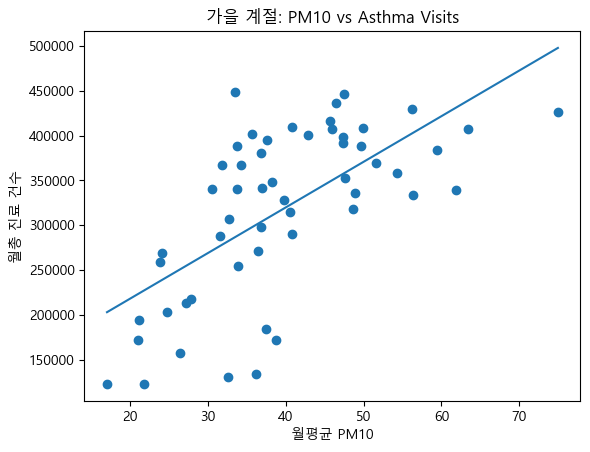

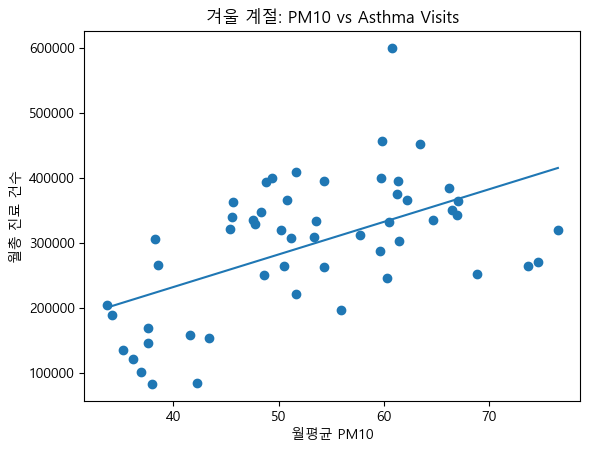

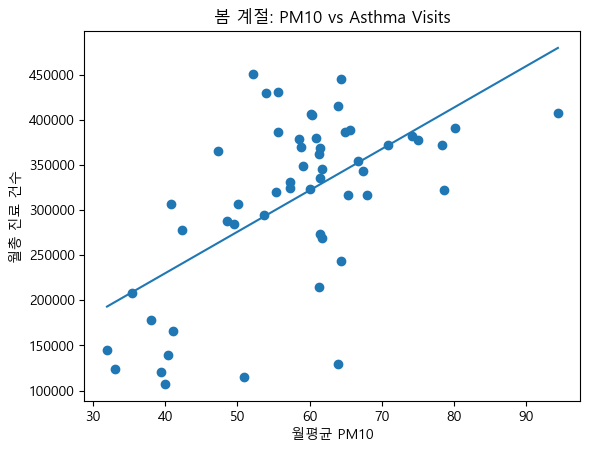

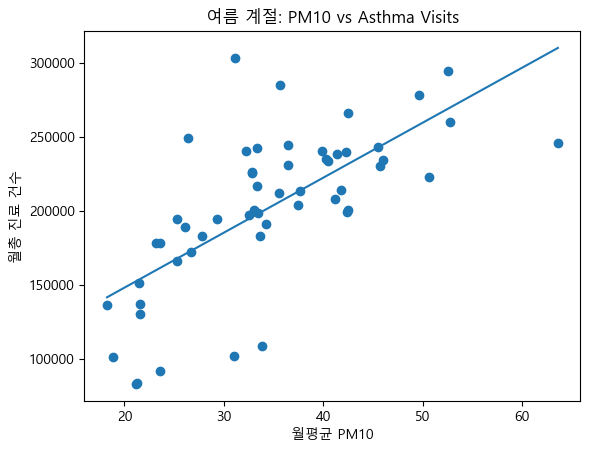

In [11]:
# 계절별 산점도 + 회귀선 (matplotlib)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

for s, sub in eda_df.groupby('season'):
    x, y = sub['pm10'], sub['total_visit_count']
    coef = np.polyfit(x, y, 1)
    line = np.poly1d(coef)

    plt.figure()
    plt.scatter(x, y)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, line(xs))
    plt.title(f"{s} 계절: PM10 vs Asthma Visits")
    plt.xlabel("월평균 PM10")
    plt.ylabel("월총 진료 건수")
    plt.show()

C:\Users\김남준\AppData\Local\Temp\ipykernel_11164\973787649.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_visits, labels=labels)


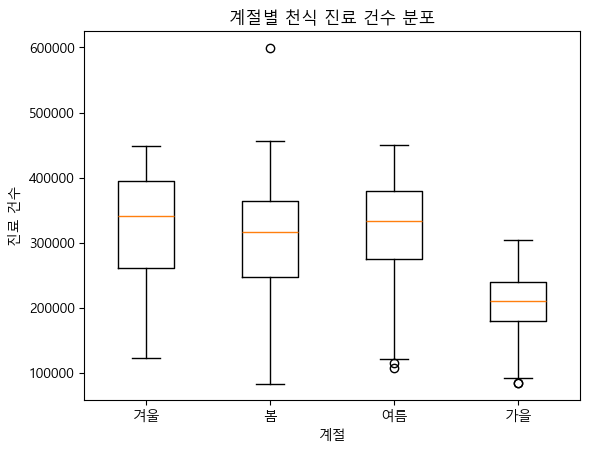

C:\Users\김남준\AppData\Local\Temp\ipykernel_11164\973787649.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_pm10, labels=labels)


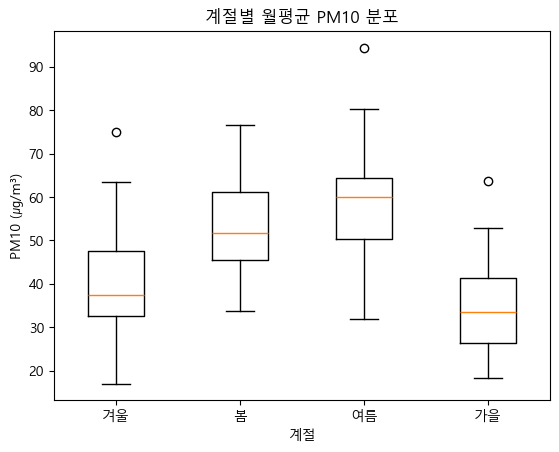

In [12]:
# 박스플롯
# 진료 건수 분포
plt.figure()
data_visits = [sub['total_visit_count'].values for _, sub in eda_df.groupby('season')]
labels = list(eda_df['season'].unique())
plt.boxplot(data_visits, labels=labels)
plt.title("계절별 천식 진료 건수 분포")
plt.xlabel("계절")
plt.ylabel("진료 건수")
plt.show()

# PM10 분포
plt.figure()
data_pm10 = [sub['pm10'].values for _, sub in eda_df.groupby('season')]
plt.boxplot(data_pm10, labels=labels)
plt.title("계절별 월평균 PM10 분포")
plt.xlabel("계절")
plt.ylabel("PM10 (㎍/m³)")
plt.show()

In [13]:
# 상호작용 회귀(Interaction Regression)
import statsmodels.formula.api as smf

df['season'] = df['season'].astype('category')
model = smf.ols('total_visit_count ~ pm10 * season', data=eda_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      total_visit_count   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     30.56
Date:                Fri, 30 May 2025   Prob (F-statistic):           7.37e-29
Time:                        02:43:55   Log-Likelihood:                -2716.2
No. Observations:                 216   AIC:                             5448.
Df Residuals:                     208   BIC:                             5475.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.162e+05   3.38e+0

In [14]:
# 카운트 데이터용 GLM 
import statsmodels.api as sm
glm = sm.GLM.from_formula(
    'total_visit_count ~ pm10 * season',
    data=eda_df, family=sm.families.Poisson()
).fit()
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      total_visit_count   No. Observations:                  216
Model:                            GLM   Df Residuals:                      208
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1205e+06
Date:                Fri, 30 May 2025   Deviance:                   4.2380e+06
Time:                        02:43:56   Pearson chi2:                 4.04e+06
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.0467      0.00

In [15]:
# Negative Binomial GLM
nb_model = smf.glm(
    'total_visit_count ~ pm10 * season',
    data=eda_df,
    family=sm.families.NegativeBinomial()
).fit()
print("\nNegative Binomial GLM 결과\n", nb_model.summary())


Negative Binomial GLM 결과
                  Generalized Linear Model Regression Results                  
Dep. Variable:      total_visit_count   No. Observations:                  216
Model:                            GLM   Df Residuals:                      208
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2919.2
Date:                Fri, 30 May 2025   Deviance:                       17.319
Time:                        02:43:56   Pearson chi2:                     15.2
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06850
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept  

C:\Users\김남준\AppData\Roaming\Python\Python311\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [16]:
# !pip install pygam

In [17]:
eda_df.head()

,year_month,season,total_visit_count,pm10
0,2006-01,겨울,599903,60.759375
1,2006-02,겨울,303703,61.396875
2,2006-03,봄,372257,78.373437
3,2006-04,봄,408013,94.417187
4,2006-05,봄,345442,61.789062


In [18]:
pm10_wide.head()

,year_month,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,수원,...,함양,남해,산청,의령,창녕,합천,경상남도,제주,서귀포,제주특별자치도
0,2006-01,65,52,60,73,72,56,37,NaN,74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,49,NaN
1,2006-02,67,55,61,72,65,55,44,NaN,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,45,NaN
2,2006-03,81,82,82,83,83,69,81,NaN,95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66,56,NaN
3,2006-04,107,93,87,111,82,82,91,NaN,129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,64,NaN
4,2006-05,63,61,52,69,64,51,55,NaN,71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,50,NaN


In [19]:
# 개별 지역(Region)별 분석
import pandas as pd
import statsmodels.formula.api as smf

df = asthma_df.groupby(['year_month','region'], as_index=False)['visit_count']\
            .sum()\
            .merge(pm10_long, on=['year_month','region'])

# 각 지역별로 PM10–visit 회귀
results = {}
for region, sub in df.groupby('region'):
    if len(sub) < 10: 
        continue  # 데이터가 너무 적은 지역은 건너뜀
    m = smf.ols('visit_count ~ pm10', data=sub).fit()
    results[region] = (m.params['pm10'], m.pvalues['pm10'])

# 결과 확인: 상위 10개 지역
top10 = sorted(results.items(), key=lambda x: abs(x[1][0]), reverse=True)[:10]
for region, (coef, pval) in top10:
    print(f"{region}: 기울기={coef:.3f}, p={pval:.3f}")

서울특별시: 기울기=544.770, p=0.000
부산광역시: 기울기=258.135, p=0.000
대구광역시: 기울기=253.610, p=0.000
인천광역시: 기울기=212.586, p=0.000
광주광역시: 기울기=137.975, p=0.000
창원: 기울기=126.563, p=0.000
대전광역시: 기울기=102.484, p=0.000
울산광역시: 기울기=92.625, p=0.000
수원: 기울기=79.741, p=0.000
성남: 기울기=62.257, p=0.000


In [20]:
# p값이 너무 낮아서 
# 서울특별시 데이터만 다시 회귀
sub = df[df['region']=='서울특별시']
m  = smf.ols('visit_count ~ pm10', data=sub).fit()

# 소수 6자리 과학표기법으로 출력
pv = m.pvalues['pm10']
print(f"서울특별시 pm10 p-value = {pv:.6e}")

서울특별시 pm10 p-value = 7.395667e-15


In [21]:
#시계열 ARIMAX 모델
import pandas as pd
import statsmodels.api as sm

ts = eda_df.set_index(pd.to_datetime(eda_df['year_month'] + '-01'))

# exog 변수로 pm10, season_code(또는 더미코딩)
exog = ts[['pm10']]

# ARIMAX(1,0,1) 예시
model = sm.tsa.SARIMAX(
    endog=ts['total_visit_count'],
    exog=exog,
    order=(1,0,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:      total_visit_count   No. Observations:                  216
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2683.836
Date:                Fri, 30 May 2025   AIC                           5375.672
Time:                        02:43:57   BIC                           5389.136
Sample:                    01-01-2006   HQIC                          5381.113
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pm10        5914.7063    182.043     32.491      0.000    5557.909    6271.504
ar.L1          0.5799      0.093      6.265      0.000       0.398       0.761
ma.L1          0.0055      0.106      0.051      0.9

C:\Users\김남준\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\김남준\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
